# Data Analysis of Healthcare Company\`s Finance 

This demostration is to help group healthcare-related company based on their financial health. In doing so, we hope to achieve reasonable groupings that could tell us how well a company is doing compared to other companies of the same sector as well as the past performance of the sector. We hope that this could be useful to better reccomend project that are suitable to their financial positions.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from hyperopt import hp, tpe, fmin
import pickle
from bokeh.io import output_file, output_notebook, curdoc
from bokeh.plotting import figure, show
from bokeh.palettes import inferno,viridis
from bokeh.models import ColumnDataSource, HoverTool, CustomJS, Circle, Panel, Tabs
from bokeh.layouts import column
from bokeh.models.widgets import CheckboxGroup

%matplotlib inline
output_notebook()

Loading BokehJS ...

## Data Inputation

Here, we try to decide on the kind of ratio to use for the classifications provided from SGX to perform the classification. We priortise profit-based ratios as the key indicator whether a company is doing very well while giving considerations to some of the rest.

In [2]:
df = pd.read_csv('assets/healthcare_sgx.csv')

In [3]:
df.set_index(['year','company'],inplace=True)

In [4]:
# keeping only ratios
# 4 profit, 1 efficency, 2 liquidity, 1 leverage
ratios = ['Return on Assets (ROA)','Return on Equity (ROE)','Operating Margin','Net Profit Margin','Asset Turnover',
                  'Current Ratio','Quick Ratio','Debt / Equity']

In [5]:
# limiting the dataset to only the ratios
df = df[ratios]

In [6]:
# casting all the data from string to numeric and input NaN to data that cannot be casted
df = df.apply(pd.to_numeric, errors='coerce')

In [7]:
df.isnull().sum()

Return on Assets (ROA)    33
Return on Equity (ROE)    38
Operating Margin           1
Net Profit Margin          2
Asset Turnover            34
Current Ratio              0
Quick Ratio                0
Debt / Equity             37
dtype: int64

In [8]:
# some companies no debt and is conservative, choice of zero seems fair
df['Debt / Equity'].fillna(0,inplace=True)

In [9]:
# drop rows with ROA,ROE and Asset Turnover (missing due to sgx data only kept for 5 year)
df.dropna(axis=0,inplace=True)

In [10]:
df.isnull().sum()

Return on Assets (ROA)    0
Return on Equity (ROE)    0
Operating Margin          0
Net Profit Margin         0
Asset Turnover            0
Current Ratio             0
Quick Ratio               0
Debt / Equity             0
dtype: int64

In [11]:
len(df)

122

In [12]:
df.sort_index(axis=0)

Return on Assets (ROA)  Return on Equity (ROE)  \
year company                                                            
2016 Aoxin Q & M                        0.026                   0.026   
     AsiaMedic                         -0.077                  -0.127   
     Asian Healthcare                   0.534                   2.188   
     Clearbridge                       -0.068                  -0.055   
     Cordlife                           0.042                   0.084   
...                                       ...                     ...   
2019 Vicplas Intl                       0.054                   0.071   
     Yunnan Energy                     -0.038                  -0.068   
2020 HC Surgical                        0.142                   0.194   
     Medinex                            0.240                   0.262   
     UG Healthcare                      0.142                   0.283   

                       Operating Margin  Net Profit Margin  Asset Turnover  \
year company                                                                 
2016 Aoxin Q & M                  0.158              0.089           0.297   
     AsiaMedic                   -0.099             -0.079           0.973   
     Asian Healthcare             0.201              0.186           2.868   
     Clearbridge                -16.389            -23.937           0.003   
     Cordlife                     0.106              0.211           0.198   
...                                 ...                ...             ...   
2019 Vicplas Intl                 0.054              0.052           1.025   
     Yunnan Energy               -0.020             -0.064           0.591   
2020 HC Surgical                  0.345              0.242           0.587   
     Medinex                      0.271              0.245           0.981   
     UG Healthcare                0.131              0.105           1.360   

                       Current Ratio  Quick Ratio  Debt / Equity  
year company                                                      
2016 Aoxin Q & M               0.639        0.578          0.000  
     AsiaMedic                 1.525        1.476          0.224  
     Asian Healthcare          1.497        1.497          0.000  
     Clearbridge               1.142        1.142          0.000  
     Cordlife                  5.007        4.974          0.607  
...                              ...          ...            ...  
2019 Vicplas Intl              2.271        1.786          0.148  
     Yunnan Energy            11.066        9.832          0.695  
2020 HC Surgical               2.043        1.936          0.475  
     Medinex                   2.646        2.389          0.135  
     UG Healthcare             1.495        0.832          0.683  

[122 rows x 8 columns]

## Visualisation

In [13]:
df_no_index=df.reset_index()

In [14]:
# all companies
companies = list(df_no_index.company.unique())

In [15]:
def create_figure(i):
    fig = figure(title=i,x_axis_label='Year', y_axis_label='Ratios',tools="pan,box_select",plot_width=900, plot_height=900,toolbar_location="above")
    #  create a coloring for each of the 33 companies
    for color,company in zip(viridis(33),companies):
        # setting the dataset to use
        company_data=df_no_index[df_no_index.company==company]
        # create a trend line
        company_line=fig.line(source=company_data,x='year',y=i,legend_label=company,color=color)
        # hide the trend line by default
        company_line.visible=False
    # set a interactive legend outside graph
    fig.add_layout(fig.legend[0], 'left')
    fig.legend.click_policy="hide"
    # Hover tool with vline mode and cap it to 3 decimal place 0.000
    hover = HoverTool(tooltips=[(i, "@{" + i + "}{0.000}"),('Year','@year'),('Company', '@{company}')])
    fig.add_tools(hover)
    tab = Panel(child=fig,title=i)
    return tab

In [16]:
# creating the figures and showing them all
tab_list=[]
for i in ratios:
    tab_list.append(create_figure(i))

layout=Tabs(tabs=tab_list)
show(layout)

# Clustering

In [17]:
data = df.to_numpy()
# scaling the data to match
ss= StandardScaler()
transformed_data = ss.fit_transform(data)

## KMeans

In [18]:
# 3 clusters
kmean=KMeans(3,random_state=42)
kmean.fit_transform(transformed_data)
df['Kmeans']=kmean.predict(transformed_data)

In [19]:
# poor performing cluster
df[df.Kmeans==1]

,,Return on Assets (ROA),Return on Equity (ROE),Operating Margin,Net Profit Margin,Asset Turnover,Current Ratio,Quick Ratio,Debt / Equity,Kmeans
year,company,,,,,,,,,
2016,Clearbridge,-0.068,-0.055,-16.389,-23.937,0.003,1.142,1.142,0.000,1
2017,Clearbridge,-0.137,-0.150,-37.000,-27.517,0.005,5.695,5.684,0.027,1
2018,IX Biopharma,-0.395,-0.535,-61.931,-62.142,0.006,3.381,3.307,0.211,1
2019,IX Biopharma,-0.443,-0.630,-19.773,-19.741,0.022,7.313,6.977,0.187,1


In [20]:
df[df.Kmeans==0]

Return on Assets (ROA)  Return on Equity (ROE)  \
year company                                                         
2016 Aoxin Q & M                     0.026                   0.026   
2017 Aoxin Q & M                     0.020                   0.031   
2019 Aoxin Q & M                    -0.047                  -0.056   
2017 Alliance HC                     0.080                   0.434   
2018 Alliance HC                     0.140                   0.589   
...                                    ...                     ...   
     Vicplas Intl                    0.050                   0.062   
2019 Vicplas Intl                    0.054                   0.071   
2016 Yunnan Energy                   0.004                   0.012   
2017 Yunnan Energy                   0.077                   0.162   
2018 Yunnan Energy                  -0.010                  -0.017   

                    Operating Margin  Net Profit Margin  Asset Turnover  \
year company                                                              
2016 Aoxin Q & M               0.158              0.089           0.297   
2017 Aoxin Q & M               0.084              0.048           0.422   
2019 Aoxin Q & M              -0.072             -0.096           0.491   
2017 Alliance HC               0.063              0.059           1.355   
2018 Alliance HC               0.101              0.103           1.357   
...                              ...                ...             ...   
     Vicplas Intl              0.034              0.051           0.976   
2019 Vicplas Intl              0.054              0.052           1.025   
2016 Yunnan Energy             0.012              0.003           1.129   
2017 Yunnan Energy             0.096              0.089           0.871   
2018 Yunnan Energy            -0.005             -0.014           0.694   

                    Current Ratio  Quick Ratio  Debt / Equity  Kmeans  
year company                                                           
2016 Aoxin Q & M            0.639        0.578          0.000       0  
2017 Aoxin Q & M            3.860        3.615          0.000       0  
2019 Aoxin Q & M            1.767        1.463          0.188       0  
2017 Alliance HC            0.887        0.834          1.002       0  
2018 Alliance HC            1.127        1.056          0.623       0  
...                           ...          ...            ...     ...  
     Vicplas Intl           3.151        2.411          0.053       0  
2019 Vicplas Intl           2.271        1.786          0.148       0  
2016 Yunnan Energy          1.840        1.336          0.571       0  
2017 Yunnan Energy          1.869        1.306          0.480       0  
2018 Yunnan Energy          2.176        1.730          0.089       0  

[99 rows x 9 columns]

In [21]:
df[df.Kmeans==2]

Return on Assets (ROA)  Return on Equity (ROE)  \
year company                                                            
2018 Aoxin Q & M                       -0.002                  -0.002   
     Asian Healthcare                   0.266                   0.326   
2019 Asian Healthcare                   0.129                   0.157   
     Biolidics                         -0.404                  -0.473   
2016 Cordlife                           0.042                   0.084   
2018 Haw Par                            0.057                   0.060   
2019 Haw Par                            0.058                   0.060   
2017 HC Surgical                        0.111                   0.164   
     ISEC                               0.114                   0.125   
2018 ISEC                               0.120                   0.126   
2016 IX Biopharma                      -0.250                  -0.318   
2017 IX Biopharma                      -0.164                  -0.200   
     Medinex                            0.235                   0.289   
2018 Medinex                            0.083                   0.083   
2016 TalkMed                            0.509                   0.624   
2017 TalkMed                            0.386                   0.471   
2018 TalkMed                            0.308                   0.396   
2019 TalkMed                            0.332                   0.456   
     Yunnan Energy                     -0.038                  -0.068   

                       Operating Margin  Net Profit Margin  Asset Turnover  \
year company                                                                 
2018 Aoxin Q & M                  0.007             -0.004           0.446   
     Asian Healthcare             0.270              0.226           1.177   
2019 Asian Healthcare             0.289              0.235           0.551   
     Biolidics                   -3.340             -3.345           0.121   
2016 Cordlife                     0.106              0.211           0.198   
2018 Haw Par                      0.803              0.753           0.076   
2019 Haw Par                      0.800              0.747           0.078   
2017 HC Surgical                  0.184              0.133           0.833   
     ISEC                         0.273              0.213           0.533   
2018 ISEC                         0.278              0.215           0.557   
2016 IX Biopharma                -1.343             -1.329           0.188   
2017 IX Biopharma                -1.188             -1.158           0.141   
     Medinex                      0.328              0.309           0.761   
2018 Medinex                      0.130              0.101           0.824   
2016 TalkMed                      0.660              0.535           0.951   
2017 TalkMed                      0.628              0.508           0.758   
2018 TalkMed                      0.555              0.444           0.694   
2019 TalkMed                      0.545              0.432           0.769   
     Yunnan Energy               -0.020             -0.064           0.591   

                       Current Ratio  Quick Ratio  Debt / Equity  Kmeans  
year company                                                              
2018 Aoxin Q & M               4.805        4.280          0.004       2  
     Asian Healthcare         10.247       10.247          0.000       2  
2019 Asian Healthcare         11.348       11.348          0.000       2  
     Biolidics                 5.439        4.802          0.069       2  
2016 Cordlife                  5.007        4.974          0.607       2  
2018 Haw Par                   5.752        5.512          0.008       2  
2019 Haw Par                   6.143        5.904          0.003       2  
2017 HC Surgical               6.524        6.444          0.000       2  
     ISEC                      6.689        6.417          0.000       2  
2018 ISEC                

## SOM

If we want to be able to visualise the clustering and without an idea how many clusters should be formed, we need a method that can perform both: Self-organising map.

In general, the size of the map is acknowledged to be 2D $5\times\sqrt{n}$ where $n$ is the number of dataset we have. This calculates to approximately an $8*8$ map. However, the potential groupings forms could be too huge for analysis purpose so I have reduced it to a $6*6$ map. Our choice of neighbourhood is also based on estimations (cannot be above $n/2$ for convergence). The choice of learning rate will have to be optimize to reduce quantization error. Evolutions and iterations are estimated to be ~1000 times more than the size of the dataset but in our case the map seems to converge fairly well in about ~60000

In [22]:
# hyperparameter tuning for learning rate
som_shape = (6,6)
best_params = fmin(
    fn = lambda lr: MiniSom(som_shape[0],som_shape[1],8,sigma=3.99,learning_rate=lr,random_seed=42).quantization_error(transformed_data),
    space = hp.uniform('lr', 0.01, 1),
    algo=tpe.suggest,
    max_evals=1000)
lr = best_params['lr']
lr

100%|███████████████████████████████████████████| 1000/1000 [00:05<00:00, 181.74trial/s, best loss: 1.6644240167595519]


0.2325339955998884

In [23]:
# initialising 8*8 SOM map with pca-adjusted weights
som = MiniSom(som_shape[0],som_shape[1], 8, sigma=3.99,learning_rate=lr, random_seed = 42) 
som.pca_weights_init(transformed_data)
som.train(transformed_data, 60000)

In [24]:
# save and load weights used
# with open('assets/som.p', 'wb') as outfile:
#     pickle.dump(som, outfile)
with open('assets/som.p', 'rb') as infile:
    som = pickle.load(infile)

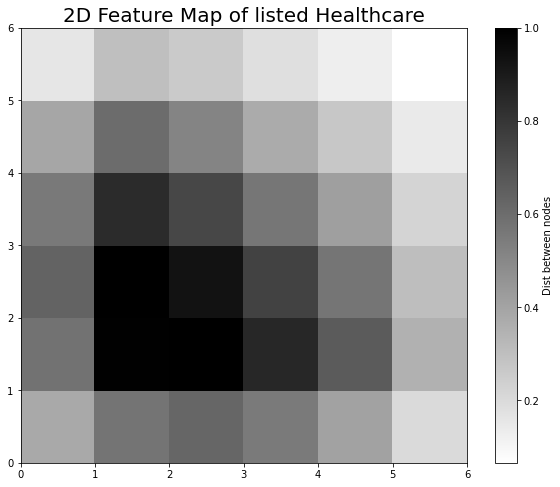

In [25]:
# plotting of the feature map obtained
plt.figure(figsize=(10,8))
plt.title('2D Feature Map of listed Healthcare',fontsize=20)
plt.pcolor(som.distance_map().T, cmap='binary') # plotting the distance map as background
plt.colorbar().set_label('Dist between nodes')

In [26]:
# each neuron (eg 0,0) represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
print(winner_coordinates)
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
print(cluster_index)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [5 5 5 5 3 3 5 5 5 4 2 2 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
  3 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 0 5 5 5 4 4 4 4 2 0 3 2 5 5 5 5
  4 3 5 3 0 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 3 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5
  3 3 4 4 3 3 5 5 5 5 4 5 5 5]]
[ 5  5  5  5  3  3  5  5  5  4  2  2  4  5  5  5 35 35  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  3  4  5  5  5  5  5  5  5  5  5  5
  5  5 35  5  4  4  4  4  0  5  5  5  4  4  4  4  8  0  3  8  5  5  5  5
  4  3  5  3  0  5  5  5  5  5  4  4  5  5  5  5  5  5  5  5  3  0  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  3  3  4  4  3  3  5  5  5  5  4  5
  5  5]


In [28]:
# rename these index to be lower values from 0 to number of groupings
mapper=dict(zip(np.unique(cluster_index),range(len(np.unique(cluster_index)))))
mapper

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 8: 5, 35: 6}

In [30]:
# append the groupings to dataframe
df['SOM'] = [mapper[i] for i in cluster_index]

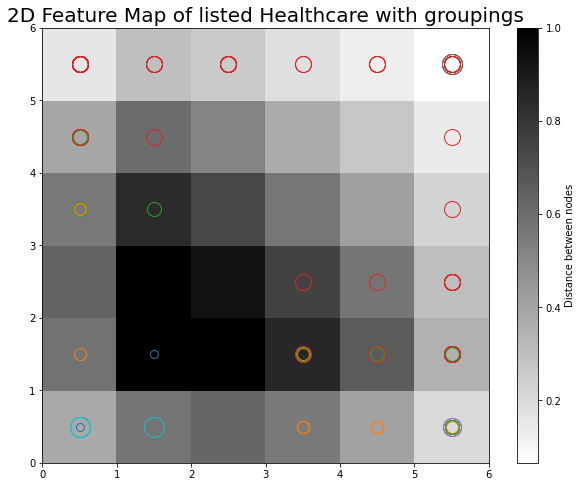

In [32]:
plt.figure(figsize=(10,8))
plt.title('2D Feature Map of listed Healthcare with groupings',fontsize=20)
# plotting the distance map as background
plt.pcolor(som.distance_map().T, cmap='binary')
# colorbar to the side
plt.colorbar().set_label('Distance between nodes')

markers = ['.', ',', 'o', 's', 'p', 'h', 'H'] 
colors = ['C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9']
marker_size = [8,12,14,16,18,20]
for cnt, xx in enumerate(transformed_data):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx +.5 is to realign the matplotlib library
    plt.plot(w[0]+.5, w[1]+.5, 'o', markerfacecolor='None',
             markeredgecolor=colors[df.SOM[cnt]-1], markersize=marker_size[df.SOM[cnt]-1], markeredgewidth=1)

## Taking a few groups to illustrate

Due to the number of grouping that was obtained and inexperience in the field, it was tough to give to all of the groups meaning. Some of the more noticable groupings are shown below

In [ ]:
# doing poorly
df[df.SOM==6]

In [ ]:
# very strong outliers
df[df.SOM==0]

In [ ]:
df.to_csv('assets/grouping.csv')